# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [122]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [123]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [124]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-28 09:00:00+09:00,50357.148438,50431.660156,50207.410156,50332.960938,0,0.0,0.0
2025-10-28 09:15:00+09:00,50325.078125,50450.378906,50325.078125,50403.140625,0,0.0,0.0
2025-10-28 09:30:00+09:00,50396.699219,50406.609375,50303.828125,50345.800781,0,0.0,0.0
2025-10-28 09:45:00+09:00,50350.390625,50447.179688,50339.859375,50392.101562,0,0.0,0.0
2025-10-28 10:00:00+09:00,50393.679688,50430.730469,50355.148438,50384.468750,0,0.0,0.0
2025-10-28 10:15:00+09:00,50383.410156,50404.578125,50288.191406,50304.031250,0,0.0,0.0
2025-10-28 10:30:00+09:00,50298.789062,50397.351562,50285.730469,50321.800781,0,0.0,0.0
2025-10-28 10:45:00+09:00,50318.519531,50354.000000,50248.859375,50248.859375,0,0.0,0.0
2025-10-28 11:00:00+09:00,50251.878906,50362.628906,50225.031250,50341.531250,0,0.0,0.0


## 前日終値の取得

In [125]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-21 00:00:00+09:00    49316.058594
2025-10-22 00:00:00+09:00    49307.789062
2025-10-23 00:00:00+09:00    48641.609375
2025-10-24 00:00:00+09:00    49299.648438
2025-10-27 00:00:00+09:00    50512.320312
2025-10-28 00:00:00+09:00    50136.628906
Name: Close, dtype: float64


Date
2025-10-27 00:00:00+09:00    50512.320312
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [126]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-155.17


## ローソク足チャート（小さいサイズ）

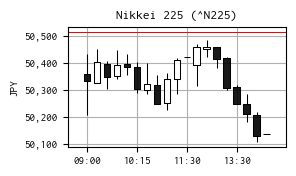

In [127]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [128]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [129]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-27 09:00:00+09:00,153.061005,153.153000,152.914001,153.136002,0,0.0,0.0
2025-10-27 09:15:00+09:00,153.143005,153.143005,153.016998,153.031998,0,0.0,0.0
2025-10-27 09:30:00+09:00,153.031998,153.048996,152.912994,152.927994,0,0.0,0.0
2025-10-27 09:45:00+09:00,152.925003,152.951004,152.820999,152.891006,0,0.0,0.0
2025-10-27 10:00:00+09:00,152.886002,152.990005,152.725998,152.735001,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-28 13:30:00+09:00,152.177994,152.225998,151.998001,152.026993,0,0.0,0.0
2025-10-28 13:45:00+09:00,152.024994,152.037994,151.847000,151.873001,0,0.0,0.0
2025-10-28 14:00:00+09:00,151.873001,151.934998,151.813995,151.901001,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [130]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-28 09:00:00+09:00,330.089597,330.578019,329.108067,329.931048
2025-10-28 09:15:00+09:00,329.978886,330.800477,329.978886,330.490738
2025-10-28 09:30:00+09:00,330.580703,330.645709,329.971508,330.246831
2025-10-28 09:45:00+09:00,330.181660,330.816372,330.112599,330.455187
2025-10-28 10:00:00+09:00,330.879956,331.123228,330.626963,330.819478
2025-10-28 10:15:00+09:00,330.474049,330.612894,329.849492,329.953389
2025-10-28 10:30:00+09:00,330.165881,330.812854,330.080163,330.316932
2025-10-28 10:45:00+09:00,330.176175,330.408988,329.719084,329.719084
2025-10-28 11:00:00+09:00,329.799491,330.526335,329.623291,330.387873


### 前日の終値のドル円レートから、前日の終値のドル換算

In [131]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-27 15:15:00+09:00


np.float64(153.0050048828125)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 330.1350851312851


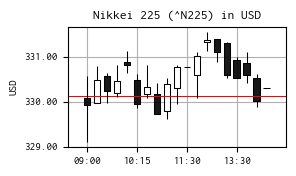

In [132]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()